In [25]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd() / "notebooks"))  # so we can import _utils from notebooks/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from _utils import get_data_dir
from scipy.stats import norm
import seaborn as sns

DATA_DIR = get_data_dir()
DATA_DIR

WindowsPath('C:/Users/AdamR/OneDrive/UCSB/VIU/HonorsThesis/data')

In [26]:
# === Load Gemini-2.5-Pro angle estimation CSVs for 50_50, 80_20, and 100_0 ===
from pathlib import Path
import pandas as pd

ROOT = DATA_DIR  # <-- ensure DATA_DIR points to your project root
FOLDERS = ["50_50", "80_20", "100_0"]
SUBPATH = "angle_estimations/gemini-2.5-pro.csv"

def safe_read_csv(path: Path, **kwargs) -> pd.DataFrame:
    """Robust CSV reader with fallback parsing."""
    defaults = dict(low_memory=False, encoding_errors="ignore")
    defaults.update(kwargs)
    try:
        return pd.read_csv(path, **defaults)
    except Exception:
        return pd.read_csv(path, engine="python", sep=None, **defaults)

def load_gemini_dataset(folder: Path) -> pd.DataFrame:
    """Load only the Gemini-2.5-Pro CSV from angle_estimations/ subfolder."""
    gemini_path = folder / SUBPATH
    if not gemini_path.exists():
        raise FileNotFoundError(f"Missing {SUBPATH} in {folder}")
    df = safe_read_csv(gemini_path)
    df["condition"] = folder.name  # tag condition (50_50, 80_20, 100_0)
    return df, gemini_path

# === Main loading loop ===
datasets = {}
records = []

for name in FOLDERS:
    folder = ROOT / name
    if not folder.exists():
        print(f"⚠️ Warning: Folder '{name}' not found under {ROOT}")
        continue

    try:
        df, path = load_gemini_dataset(folder)
        datasets[name] = df
        records.append({
            "condition": name,
            "n_rows": len(df),
            "n_cols": df.shape[1],
            "path": str(path.resolve())
        })
        print(f"✅ Loaded Gemini data for {name}: {path}")
    except FileNotFoundError as e:
        print("⚠️", e)

# === Summary table ===
gemini_index = pd.DataFrame.from_records(records).sort_values("condition").reset_index(drop=True)

# === Parse Gemini GPT_response into separate columns for each condition ===
import pandas as pd
import numpy as np

def parse_gpt_response(resp):
    """
    Parse GPT_response string of the form 'angle1, angle2, decision'
    → (float, float, str). Returns NaN if parsing fails.
    """
    if not isinstance(resp, str):
        return (np.nan, np.nan, np.nan)
    parts = [p.strip() for p in resp.split(",")]
    if len(parts) < 3:
        return (np.nan, np.nan, np.nan)
    try:
        a1 = float(parts[0])
        a2 = float(parts[1])
        decision = parts[2].lower()
        return (a1, a2, decision)
    except Exception:
        return (np.nan, np.nan, np.nan)

# --- Parse function to add columns
def add_parsed_columns(df):
    df = df.copy()
    parsed = df["GPT_response"].apply(parse_gpt_response)
    df[["est_angle_1", "est_angle_2", "decision"]] = pd.DataFrame(parsed.tolist(), index=df.index)
    return df


gemini_50_50 = add_parsed_columns(datasets.get("50_50", pd.DataFrame()))
gemini_80_20 = add_parsed_columns(datasets.get("80_20", pd.DataFrame()))
gemini_100_0 = add_parsed_columns(datasets.get("100_0", pd.DataFrame()))


datasets["50_50_parsed"] = gemini_50_50
datasets["80_20_parsed"] = gemini_80_20
datasets["100_0_parsed"] = gemini_100_0

gemini_master = pd.concat(
    [gemini_50_50, gemini_80_20, gemini_100_0],
    ignore_index=True
)



✅ Loaded Gemini data for 50_50: C:\Users\AdamR\OneDrive\UCSB\VIU\HonorsThesis\data\50_50\angle_estimations\gemini-2.5-pro.csv
✅ Loaded Gemini data for 80_20: C:\Users\AdamR\OneDrive\UCSB\VIU\HonorsThesis\data\80_20\angle_estimations\gemini-2.5-pro.csv
✅ Loaded Gemini data for 100_0: C:\Users\AdamR\OneDrive\UCSB\VIU\HonorsThesis\data\100_0\angle_estimations\gemini-2.5-pro.csv


In [27]:
# === Load human + model CSVs for 50_50, 80_20, and 100_0 datasets ===
from pathlib import Path
import pandas as pd

ROOT = DATA_DIR  # already defined in your environment
FOLDERS = ["50_50", "80_20", "100_0"]

def safe_read_csv(path: Path, **kwargs) -> pd.DataFrame:
    """Robust CSV reader with fallback parsing."""
    defaults = dict(low_memory=False, encoding_errors="ignore")
    defaults.update(kwargs)
    try:
        return pd.read_csv(path, **defaults)
    except Exception:
        return pd.read_csv(path, engine="python", sep=None, **defaults)

def load_dataset(folder: Path) -> dict:
    """Load human_data.csv and all model decision CSVs inside 'decisions/'."""
    human_path = folder / "human_data.csv"
    decisions_dir = folder / "decisions"

    if not human_path.exists():
        raise FileNotFoundError(f"Missing human_data.csv in {folder}")
    if not decisions_dir.exists():
        raise FileNotFoundError(f"Missing 'decisions/' subfolder in {folder}")

    # Load human data
    human_df = safe_read_csv(human_path)

    # Load each model file
    models = {}
    for csv_path in sorted(decisions_dir.glob("*.csv")):
        model_name = csv_path.stem
        models[model_name] = safe_read_csv(csv_path)

    return {
        "human": human_df,
        "human_path": human_path,
        "models": models,
        "model_paths": {m: csv_path for m, csv_path in zip(models.keys(), sorted(decisions_dir.glob('*.csv')))}
    }

# === Main loading loop ===
datasets: dict[str, dict] = {}
records = []

for name in FOLDERS:
    folder = ROOT / name
    if not folder.exists():
        print(f"⚠️ Warning: Folder '{name}' not found under {ROOT}")
        continue

    data_bundle = load_dataset(folder)
    datasets[name] = data_bundle

    # Record human file
    h = data_bundle["human"]
    records.append({
        "dataset": name,
        "kind": "human",
        "name": "human_data",
        "n_rows": len(h),
        "n_cols": h.shape[1],
        "path": str(data_bundle["human_path"].resolve())
    })

    # Record model files
    for mname, mdf in data_bundle["models"].items():
        records.append({
            "dataset": name,
            "kind": "model",
            "name": mname,
            "n_rows": len(mdf),
            "n_cols": mdf.shape[1],
            "path": str((folder / "decisions" / f"{mname}.csv").resolve())
        })

# === Summary table ===
assignment_index = pd.DataFrame.from_records(records).sort_values(
    ["dataset", "kind", "name"]
).reset_index(drop=True)

# === Combine Human CSVs across 50_50, 80_20, 100_0 ===
import pandas as pd
from pathlib import Path

# Extract the individual human DataFrames
human50_50 = datasets["50_50"]["human"]
human80_20 = datasets["80_20"]["human"]
human100_0 = datasets["100_0"]["human"]

# If columns match (identical structure):
human_master = pd.concat(
    [human50_50, human80_20, human100_0],
    ignore_index=True
)

In [28]:
# === Harmonize column names ===
hum = human_master
mod = gemini_master

hum = hum.rename(columns={
    "stimID": "stim_id",
    "response": "response"
})

mod = mod.rename(columns={
    "image_id": "stim_id",
    "decision": "response"
})

mod["response"] = mod["response"].map({"present": 1, "absent": 0})
mod = mod.drop(columns=["GPT_response"])


# Add a domain label
hum["domain"] = "human"
mod["domain"] = "model"

# Add ID columns for grouping
hum["who"] = hum["participantID"]
mod["who"] = "Gemini"

hum = hum.drop(columns=["participantID"])
hum["confidence"] = hum["response"]
hum["response"] = (hum["response"] >= 4).astype(int)
hum["condition"] = hum["condition"].map({
    "condition_1": "80_20",
    "condition_2": "50_50",
    "condition_3": "100_0"
})
hum = hum[["stim_id", "condition", "domain", "who", "side_selected", "cue_points", "line1_angle", "line2_angle", "valid_cue", "TP", "response", "confidence"]]
mod = mod[["stim_id", "condition", "domain", "who", "side_selected", "cue_points", "line1_angle", "line2_angle", "valid_cue", "TP", "est_angle_1", "est_angle_2", "response"]]

COND_ORDER  = ["50_50","80_20","100_0"]
COND_TO_NUM = {"50_50":0,"80_20":1,"100_0":2}

for df in (hum, mod):
    df["condition"] = df["condition"].astype(str).str.replace("/", "_").str.strip()
    df["condition"] = pd.Categorical(df["condition"], categories=COND_ORDER, ordered=True)
    df["reliability_num"] = df["condition"].map(COND_TO_NUM)

display(hum.head())
display(mod.head())

,stim_id,condition,domain,who,side_selected,cue_points,line1_angle,line2_angle,valid_cue,TP,response,confidence,reliability_num
0,100,50_50,human,SA,1,2,14.314827,1.921956,False,True,1,6,0
1,845,50_50,human,SA,1,2,15.054317,4.222230,False,True,1,5,0
2,245,50_50,human,SA,1,1,14.314827,6.508956,True,True,1,4,0
3,72,50_50,human,SA,2,2,8.775056,15.054317,True,True,1,4,0
4,469,50_50,human,SA,2,2,4.222230,19.885165,True,True,1,4,0


,stim_id,condition,domain,who,side_selected,cue_points,line1_angle,line2_angle,valid_cue,TP,est_angle_1,est_angle_2,response,reliability_num
0,100,50_50,model,Gemini,1,2,14.314827,1.921956,False,True,-14.9,-1.0,1,0
1,845,50_50,model,Gemini,1,2,15.054317,4.222230,False,True,-14.5,2.0,1,0
2,245,50_50,model,Gemini,1,1,14.314827,6.508956,True,True,-13.8,-3.2,1,0
3,72,50_50,model,Gemini,2,2,8.775056,15.054317,True,True,5.1,15.5,1,0
4,469,50_50,model,Gemini,2,2,4.222230,19.885165,True,True,3.1,18.9,1,0


C:\Users\AdamR\AppData\Local\Temp\ipykernel_25052\757353966.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby([who_col,"condition"], dropna=False)
C:\Users\AdamR\AppData\Local\Temp\ipykernel_25052\757353966.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats = grp.apply(lambda d: pd.Series({
C:\Users\AdamR\AppData\Local\Temp\ipykernel_25052\757353966.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=Fa

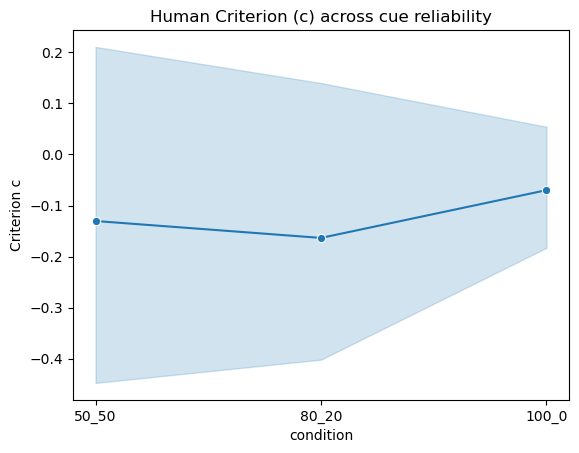

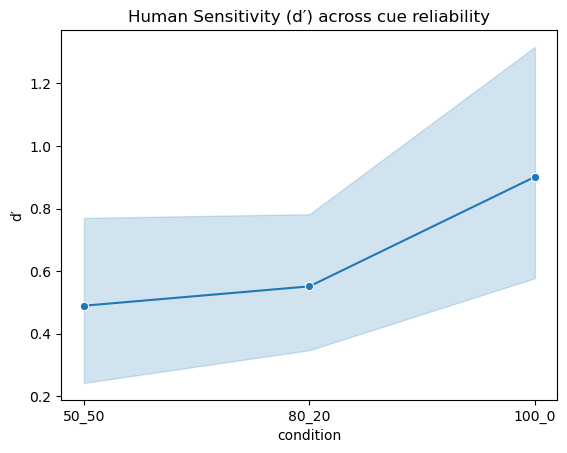

In [29]:
def zsafe(p):
    p = np.clip(p, 1e-6, 1 - 1e-6)
    return norm.ppf(p)

def sdt_metrics(df, who_col="who", tp_col="TP", resp_col="response"):
    grp = df.groupby([who_col,"condition"], dropna=False)
    stats = grp.apply(lambda d: pd.Series({
        "hits": ((d[tp_col]==1)&(d[resp_col]==1)).sum(),
        "miss": ((d[tp_col]==1)&(d[resp_col]==0)).sum(),
        "fa":   ((d[tp_col]==0)&(d[resp_col]==1)).sum(),
        "cr":   ((d[tp_col]==0)&(d[resp_col]==0)).sum(),
        "n_sig": (d[tp_col]==1).sum(),
        "n_noise": (d[tp_col]==0).sum()
    })).reset_index()

    stats["hit_rate"] = (stats["hits"]+0.5)/(stats["n_sig"]+1)
    stats["fa_rate"]  = (stats["fa"]+0.5)/(stats["n_noise"]+1)
    stats["dprime"]   = zsafe(stats["hit_rate"]) - zsafe(stats["fa_rate"])
    stats["criterion"] = -0.5*(zsafe(stats["hit_rate"]) + zsafe(stats["fa_rate"]))
    return stats

human_sdt = sdt_metrics(hum, who_col="who", tp_col="TP", resp_col="response")
human_sdt["domain"] = "human"


model_sdt = sdt_metrics(mod, who_col="who", tp_col="TP", resp_col="response")
model_sdt["domain"] = "model"

sns.lineplot(data=human_sdt, x="condition", y="criterion", marker="o")
plt.title("Human Criterion (c) across cue reliability")
plt.ylabel("Criterion c")
plt.show()

sns.lineplot(data=human_sdt, x="condition", y="dprime", marker="o")
plt.title("Human Sensitivity (d′) across cue reliability")
plt.ylabel("d′")
plt.show()


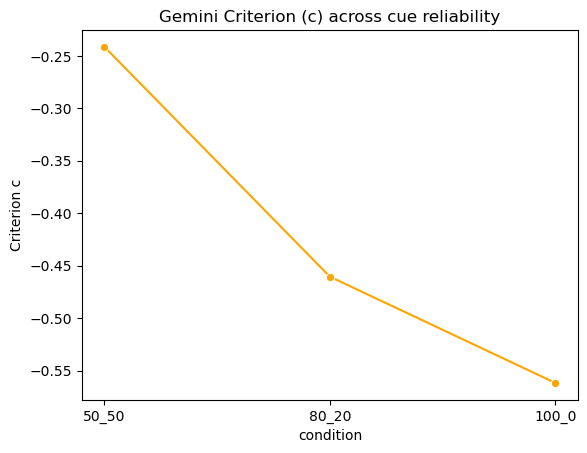

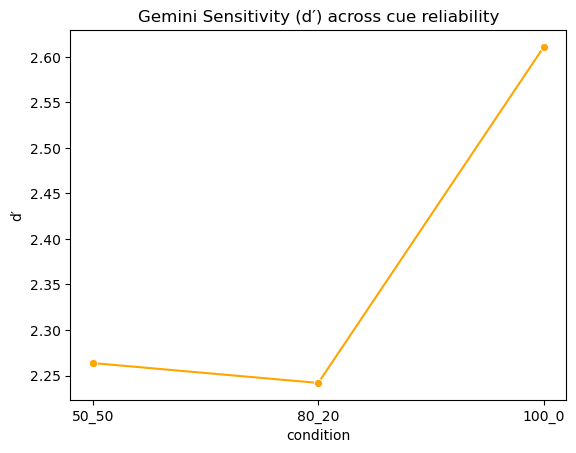

In [30]:
sns.lineplot(data=model_sdt, x="condition", y="criterion", marker="o", color="orange")
plt.title("Gemini Criterion (c) across cue reliability")
plt.ylabel("Criterion c")
plt.show()

sns.lineplot(data=model_sdt, x="condition", y="dprime", marker="o", color="orange")
plt.title("Gemini Sensitivity (d′) across cue reliability")
plt.ylabel("d′")
plt.show()


In [31]:
def compute_flexibility(df):
    pivot_c = df.pivot(index="who", columns="condition", values="criterion")
    pivot_d = df.pivot(index="who", columns="condition", values="dprime")
    pivot_c["delta_c"] = pivot_c["100_0"] - pivot_c["50_50"]
    pivot_d["delta_dprime"] = pivot_d["100_0"] - pivot_d["50_50"]
    return pivot_c.join(pivot_d[["delta_dprime"]]).reset_index()

human_flex = compute_flexibility(human_sdt)
model_flex = compute_flexibility(model_sdt)

print("Human flexibility summary:")
print(human_flex[["delta_c","delta_dprime"]].describe())

print("\nModel flexibility summary:")
print(model_flex[["delta_c","delta_dprime"]].describe())


Human flexibility summary:
condition    delta_c  delta_dprime
count      12.000000     12.000000
mean        0.060406      0.411739
std         0.520409      0.575863
min        -0.995111     -0.204620
25%        -0.120657      0.182892
50%         0.125611      0.278020
75%         0.245604      0.394647
max         1.089540      2.062501

Model flexibility summary:
condition   delta_c  delta_dprime
count      1.000000      1.000000
mean      -0.320314      0.347145
std             NaN           NaN
min       -0.320314      0.347145
25%       -0.320314      0.347145
50%       -0.320314      0.347145
75%       -0.320314      0.347145
max       -0.320314      0.347145


In [32]:
# ============================================================
# SUMMARY + FLEXIBILITY STATISTICS
# ============================================================

import pandas as pd
from scipy.stats import ttest_ind

# --- 1. Mean d′ and criterion per condition for each domain ---
def summarize_domain(df, domain_name):
    summary = (df.groupby("condition")[["dprime","criterion"]]
                  .mean()
                  .reset_index())
    summary["domain"] = domain_name
    return summary

human_summary = summarize_domain(human_sdt, "Human")
model_summary = summarize_domain(model_sdt, "Gemini")

display("=== Mean d′ and Criterion by Condition ===")
display(pd.concat([human_summary, model_summary], ignore_index=True))

# --- 2. Compute flexibility (Δc and Δd′) per domain ---
def summarize_flex(flex_df, domain_name):
    return pd.DataFrame({
        "domain": [domain_name],
        "mean_Δc": [flex_df["delta_c"].mean()],
        "sd_Δc": [flex_df["delta_c"].std()],
        "mean_Δd′": [flex_df["delta_dprime"].mean()],
        "sd_Δd′": [flex_df["delta_dprime"].std()],
        "n": [len(flex_df)]
    })

human_flex_summary = summarize_flex(human_flex, "Human")
model_flex_summary = summarize_flex(model_flex, "Gemini")

flex_summary = pd.concat([human_flex_summary, model_flex_summary], ignore_index=True)

display("=== Flexibility (Δc and Δd′) ===")
display(flex_summary)

# --- 3. Statistical comparison of flexibility (independent t-tests) ---
t_c, p_c = ttest_ind(human_flex["delta_c"], model_flex["delta_c"], equal_var=False)
t_d, p_d = ttest_ind(human_flex["delta_dprime"], model_flex["delta_dprime"], equal_var=False)

# --- 4. Quick textual interpretation helper ---
def interpret_results(human, model):
    print("\n=== INTERPRETATION SUMMARY ===")
    print(f"Human Δc: {human['mean_Δc'].values[0]:.3f}  | Gemini Δc: {model['mean_Δc'].values[0]:.3f}")
    print(f"Human Δd′: {human['mean_Δd′'].values[0]:.3f} | Gemini Δd′: {model['mean_Δd′'].values[0]:.3f}")

interpret_results(human_flex_summary, model_flex_summary)


C:\Users\AdamR\AppData\Local\Temp\ipykernel_25052\2614245264.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = (df.groupby("condition")[["dprime","criterion"]]
C:\Users\AdamR\AppData\Local\Temp\ipykernel_25052\2614245264.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = (df.groupby("condition")[["dprime","criterion"]]


'=== Mean d′ and Criterion by Condition ==='

,condition,dprime,criterion,domain
0,50_50,0.489606,-0.130227,Human
1,80_20,0.551451,-0.163363,Human
2,100_0,0.901345,-0.069821,Human
3,50_50,2.263691,-0.241450,Gemini
4,80_20,2.241886,-0.460519,Gemini
5,100_0,2.610835,-0.561764,Gemini


'=== Flexibility (Δc and Δd′) ==='

,domain,mean_Δc,sd_Δc,mean_Δd′,sd_Δd′,n
0,Human,0.060406,0.520409,0.411739,0.575863,12
1,Gemini,-0.320314,NaN,0.347145,NaN,1



=== INTERPRETATION SUMMARY ===
Human Δc: 0.060  | Gemini Δc: -0.320
Human Δd′: 0.412 | Gemini Δd′: 0.347


In [33]:
print(list(hum.columns))
display(hum.head())

['stim_id', 'condition', 'domain', 'who', 'side_selected', 'cue_points', 'line1_angle', 'line2_angle', 'valid_cue', 'TP', 'response', 'confidence', 'reliability_num']


,stim_id,condition,domain,who,side_selected,cue_points,line1_angle,line2_angle,valid_cue,TP,response,confidence,reliability_num
0,100,50_50,human,SA,1,2,14.314827,1.921956,False,True,1,6,0
1,845,50_50,human,SA,1,2,15.054317,4.222230,False,True,1,5,0
2,245,50_50,human,SA,1,1,14.314827,6.508956,True,True,1,4,0
3,72,50_50,human,SA,2,2,8.775056,15.054317,True,True,1,4,0
4,469,50_50,human,SA,2,2,4.222230,19.885165,True,True,1,4,0


In [34]:
# %%
import pandas as pd
from typing import Iterable

# --------------------------
# Aggregation helper rules
# --------------------------
def _binary_majority(series: pd.Series, tie_to_one: bool = True) -> int:
    """
    Majority vote on a 0/1 series.
    Tie rule: mean >= 0.5 -> 1 (if tie_to_one=True), else 0.
    """
    m = series.mean()
    return int(m >= 0.5) if tie_to_one else int(m > 0.5)

def _binary_average(series: pd.Series, tie_to_one: bool = True) -> int:
    """
    'Average' rule on a 0/1 series (equivalent to majority with the same tie rule).
    Kept separate for clarity and future extensions.
    """
    m = series.mean()
    return int(m >= 0.5) if tie_to_one else int(m > 0.5)

def _majority_with_exception(
    resp_series: pd.Series,
    conf_series: pd.Series,
    exception_conf_values: Iterable[int] = (5, 6),
    tie_to_one: bool = True
) -> int:
    """
    Majority-with-exception:
      - If ANY participant's confidence is in `exception_conf_values`, output 1.
      - Otherwise fall back to majority rule on the binary response series.
    """
    # exception trigger
    if conf_series.isin(exception_conf_values).any():
        return 1
    # fallback
    return _binary_majority(resp_series, tie_to_one=tie_to_one)

# --------------------------
# Trial-level aggregator
# --------------------------
def compute_trial_aggregates(
    df: pd.DataFrame,
    group_cols=("stim_id", "condition", "domain"),
    response_col="response",
    confidence_col="confidence",
    exception_conf_values=(5, 6),
    tie_to_one=True
) -> pd.DataFrame:
    """
    Returns one row per unique trial (by group_cols) with aggregation decisions.

    Expected columns in df:
      - group_cols (e.g., stim_id, condition, domain)
      - response_col: binary 0/1 individual decisions
      - confidence_col: integer/ordinal confidences
      - 'who' (optional): used only for counting unique contributors

    Output columns:
      - maj_decision: majority vote (0/1)
      - avg_decision: average rule (0/1)
      - mwe_decision: majority-with-exception (0/1)
      - n_raters: number of unique contributors in the trial
    """
    # safety checks
    for c in [*group_cols, response_col, confidence_col]:
        if c not in df.columns:
            raise KeyError(f"Missing required column: {c}")

    grouped = df.groupby(list(group_cols), dropna=False)

    def _apply(g):
        return pd.Series({
            "maj_decision": _binary_majority(g[response_col], tie_to_one=tie_to_one),
            "avg_decision": _binary_average(g[response_col], tie_to_one=tie_to_one),
            "mwe_decision": _majority_with_exception(
                g[response_col],
                g[confidence_col],
                exception_conf_values=exception_conf_values,
                tie_to_one=tie_to_one
            ),
            "n_raters": g.get("who", g.index).nunique()
        })

    out = grouped.apply(_apply).reset_index()
    return out

trial_aggregates = compute_trial_aggregates(
    hum,
    group_cols=("stim_id", "condition", "domain"),
    response_col="response",
    confidence_col="confidence",
    exception_conf_values=(6, 6),   # as requested: if any has 5 or 6 -> 1
    tie_to_one=True                 # ties go to 1; change to False if you prefer 0
)


tp_per_trial = (
    hum.groupby(["stim_id", "condition", "domain"], dropna=False)["TP"]
       .first()
       .reset_index()
)

trial_aggregates = trial_aggregates.merge(tp_per_trial, on=["stim_id", "condition", "domain"], how="left")

# Preview
display(trial_aggregates.head())



C:\Users\AdamR\AppData\Local\Temp\ipykernel_25052\1472928523.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(list(group_cols), dropna=False)
C:\Users\AdamR\AppData\Local\Temp\ipykernel_25052\1472928523.py:87: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = grouped.apply(_apply).reset_index()
C:\Users\AdamR\AppData\Local\Temp\ipykernel_25052\1472928523.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obs

,stim_id,condition,domain,maj_decision,avg_decision,mwe_decision,n_raters,TP
0,1,50_50,human,1,1,1,12,False
1,1,80_20,human,1,1,1,12,False
2,1,100_0,human,1,1,1,12,False
3,2,50_50,human,0,0,1,12,False
4,2,80_20,human,0,0,0,12,False


In [35]:
# --- Fit + apply Weighted Linear Combination (WLC) per condition ---
def fit_wlc_weights(
    df: pd.DataFrame,
    use_confidence: bool = True,
    lam: float = 1e-3,
    who_col: str = "who",
    cond_col: str = "condition",
    tp_col: str = "TP",
    resp_col: str = "response",
    conf_col: str = "confidence"
):
    """
    Returns:
      weights: dict[condition] -> pd.Series indexed by who (participants), containing w
      criteria: dict[condition] -> float, the threshold on the linear score that maximizes in-sample accuracy
    Method (per condition):
      1) Build trial x participant matrix X of individual inputs (confidence if available else binary response).
      2) Compute Δμ = mean(X|TP=1) - mean(X|TP=0)  (participant-wise).
      3) Estimate Σ = covariance across participants of X (rows=centered trials).
      4) Ridge weights: w = (Σ + λI)^(-1) Δμ.
      5) Decision scores s = X_centered @ w ; choose criterion that maximizes accuracy on these scores.
    """
    data_input = conf_col if use_confidence and conf_col in df.columns else resp_col

    # Prepare (trial = (stim_id, condition)) x participant matrix for each condition
    # Average duplicates per (stim_id, who, condition) just in case
    base = (df
            .groupby(["stim_id", cond_col, who_col], dropna=False)[[data_input, tp_col]]
            .mean()
            .reset_index())

    weights = {}
    criteria = {}

    for cond, sub in base.groupby(cond_col, dropna=False):
        # pivot to trials x participants
        X = sub.pivot(index=["stim_id", cond_col], columns=who_col, values=data_input).sort_index()
        y = (sub.drop_duplicates(["stim_id", cond_col])    # TP is constant per trial in your design
               .set_index(["stim_id", cond_col])[tp_col]
               .reindex(X.index))

        # center columns (participant-wise)
        Xc = X - X.mean(axis=0)

        # participant-wise Δμ
        mu_sig = Xc[y == 1].mean(axis=0)
        mu_noise = Xc[y == 0].mean(axis=0)
        delta_mu = (mu_sig - mu_noise).fillna(0.0)

        # covariance across participants
        # note: rowvar=False expects observations in rows, variables in columns (participants are variables)
        Sigma = np.cov(Xc.fillna(Xc.mean()).to_numpy(), rowvar=False)
        # ridge regularization
        p = Xc.shape[1]
        Sigma_r = Sigma + lam * np.eye(p)

        # weights
        try:
            w = np.linalg.solve(Sigma_r, delta_mu.to_numpy())
        except np.linalg.LinAlgError:
            w = np.linalg.pinv(Sigma_r) @ delta_mu.to_numpy()

        w = pd.Series(w, index=Xc.columns, name="w")
        weights[cond] = w

        # score per trial and best threshold (maximize accuracy in-sample)
        s = Xc.fillna(0.0).to_numpy() @ w.to_numpy()

        # choose criterion by sweeping all midpoints between sorted scores
        # decision: (s >= c) -> 1 else 0  (ties to 1)
        order = np.argsort(s)
        s_sorted = s[order]
        y_sorted = y.to_numpy()[order]

        # candidate thresholds at midpoints (including below min & above max)
        mids = np.r_[
            s_sorted[0] - 1e-9,
            (s_sorted[:-1] + s_sorted[1:]) / 2.0,
            s_sorted[-1] + 1e-9
        ]

        # compute accuracy for each threshold
        # For speed, cumulative sums:
        # pred = (s_sorted >= c) => threshold split index
        # correct = TP==1 & pred==1  OR  TP==0 & pred==0
        # Use vectorized computation via prefix sums of positives.
        y_pos = (y_sorted == 1).astype(int)
        y_neg = 1 - y_pos

        # prefix counts if predicted 1 for suffix and 0 for prefix
        # At split k: indices [k..end] predicted 1, [0..k-1] predicted 0
        cumsum_pos = np.cumsum(y_pos[::-1])[::-1]   # suffix sum of positives
        cumsum_neg = np.cumsum(y_neg)               # prefix sum of negatives

        # find split indices for each threshold
        split_idx = np.searchsorted(s_sorted, mids, side="left")

        correct = cumsum_pos.take(split_idx, mode='clip') + cumsum_neg.take(split_idx, mode='clip')
        best_i = int(np.argmax(correct))
        c_star = float(mids[best_i])
        criteria[cond] = c_star

    return weights, criteria


def apply_wlc_and_build_trials(
    df: pd.DataFrame,
    weights: dict,
    criteria: dict,
    use_confidence: bool = True,
    who_col: str = "who",
    cond_col: str = "condition",
    tp_col: str = "TP",
    resp_col: str = "response",
    conf_col: str = "confidence"
) -> pd.DataFrame:
    """
    Applies fitted WLC per condition to produce one binary decision per trial.
    Returns DataFrame with: stim_id, condition, TP, wlc_score, wlc_decision
    """
    data_input = conf_col if use_confidence and conf_col in df.columns else resp_col

    base = (df
            .groupby(["stim_id", cond_col, who_col], dropna=False)[[data_input, tp_col]]
            .mean()
            .reset_index())

    rows = []
    for cond, sub in base.groupby(cond_col, dropna=False):
        X = sub.pivot(index=["stim_id", cond_col], columns=who_col, values=data_input).sort_index()
        y = (sub.drop_duplicates(["stim_id", cond_col])
               .set_index(["stim_id", cond_col])[tp_col]
               .reindex(X.index))

        Xc = X - X.mean(axis=0)

        w = weights[cond].reindex(Xc.columns).fillna(0.0).to_numpy()
        score = (Xc.fillna(0.0).to_numpy() @ w).astype(float)
        c_star = criteria[cond]
        decision = (score >= c_star).astype(int)

        out = pd.DataFrame({
            "stim_id": [i[0] for i in X.index],
            "condition": [i[1] for i in X.index],
            "TP": y.to_numpy(),
            "wlc_score": score,
            "wlc_decision": decision
        })
        rows.append(out)

    return pd.concat(rows, ignore_index=True)


# --- SDT summary helper (reuses your zsafe) ---
def sdt_from_binary(df, pred_col="wlc_decision", tp_col="TP", condition_col="condition", label="wlc"):
    res = []
    for cond, sub in df.groupby(condition_col, dropna=False):
        hits = ((sub[tp_col]==1) & (sub[pred_col]==1)).sum()
        miss = ((sub[tp_col]==1) & (sub[pred_col]==0)).sum()
        fa   = ((sub[tp_col]==0) & (sub[pred_col]==1)).sum()
        cr   = ((sub[tp_col]==0) & (sub[pred_col]==0)).sum()

        n_sig = (sub[tp_col]==1).sum()
        n_noise = (sub[tp_col]==0).sum()

        hit_rate = (hits + 0.5) / (n_sig + 1)
        fa_rate  = (fa   + 0.5) / (n_noise + 1)
        dprime   = zsafe(hit_rate) - zsafe(fa_rate)
        criterion = -0.5 * (zsafe(hit_rate) + zsafe(fa_rate))
        accuracy = (hits + cr) / (n_sig + n_noise)

        res.append({
            "aggregation": label,
            "condition": cond,
            "n_trials": len(sub),
            "accuracy": accuracy,
            "hit_rate": hit_rate,
            "fa_rate": fa_rate,
            "dprime": dprime,
            "criterion": criterion
        })
    return pd.DataFrame(res)


# =========================
# Run WLC and append table
# =========================

# Fit weights/criteria per condition using HUMANS; set use_confidence=True to use the 1–10 ratings
wlc_weights, wlc_criteria = fit_wlc_weights(
    hum, use_confidence=True, lam=1e-3,
    who_col="who", cond_col="condition", tp_col="TP",
    resp_col="response", conf_col="confidence"
)

# Apply to build one decision per trial
wlc_trials = apply_wlc_and_build_trials(
    hum, wlc_weights, wlc_criteria,
    use_confidence=True,
    who_col="who", cond_col="condition", tp_col="TP",
    resp_col="response", conf_col="confidence"
)

# Summarize SDT metrics per condition
wlc_sdt = sdt_from_binary(wlc_trials, pred_col="wlc_decision", tp_col="TP", condition_col="condition", label="wlc")

# Append to your existing table (agg_sdt or agg_with_best)
agg_plus_wlc = (
    pd.concat([agg_with_best if 'agg_with_best' in globals() else agg_sdt, wlc_sdt], ignore_index=True)
      .sort_values(["aggregation","condition"])
      .reset_index(drop=True)
)

display(wlc_sdt)
display(agg_plus_wlc)

# (Optional) save
# agg_plus_wlc.to_csv("aggregation_sdt_with_best_and_wlc.csv", index=False)


C:\Users\AdamR\AppData\Local\Temp\ipykernel_25052\1939076600.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["stim_id", cond_col, who_col], dropna=False)[[data_input, tp_col]]
C:\Users\AdamR\AppData\Local\Temp\ipykernel_25052\1939076600.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cond, sub in base.groupby(cond_col, dropna=False):
C:\Users\AdamR\AppData\Local\Temp\ipykernel_25052\1939076600.py:124: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to ad

,aggregation,condition,n_trials,accuracy,hit_rate,fa_rate,dprime,criterion
0,wlc,100_0,1000,0.910,0.929142,0.110778,2.691827,-0.123515
1,wlc,50_50,1000,0.798,0.789421,0.194611,1.665444,0.028308
2,wlc,80_20,1000,0.869,0.897206,0.160679,2.257461,-0.137058


,aggregation,condition,n_trials,accuracy,hit_rate,fa_rate,dprime,criterion,who
0,avg,100_0,1000,0.784,0.925150,0.358283,1.803641,-0.538769,NaN
1,avg,50_50,1000,0.637,0.823353,0.549900,0.802811,-0.526815,NaN
2,avg,80_20,1000,0.656,0.851297,0.539920,0.941781,-0.571123,NaN
3,best_individual,100_0,1000,0.874,0.869261,0.122754,2.284234,0.019210,UR
4,best_individual,50_50,1000,0.704,0.921158,0.513972,1.377872,-0.723966,AG
5,best_individual,80_20,1000,0.703,0.639721,0.234531,1.081718,0.183147,KM
6,maj,100_0,1000,0.784,0.925150,0.358283,1.803641,-0.538769,NaN
7,maj,50_50,1000,0.637,0.823353,0.549900,0.802811,-0.526815,NaN
8,maj,80_20,1000,0.656,0.851297,0.539920,0.941781,-0.571123,NaN
9,mwe,100_0,1000,0.705,0.985030,0.575848,1.979598,-1.181083,NaN


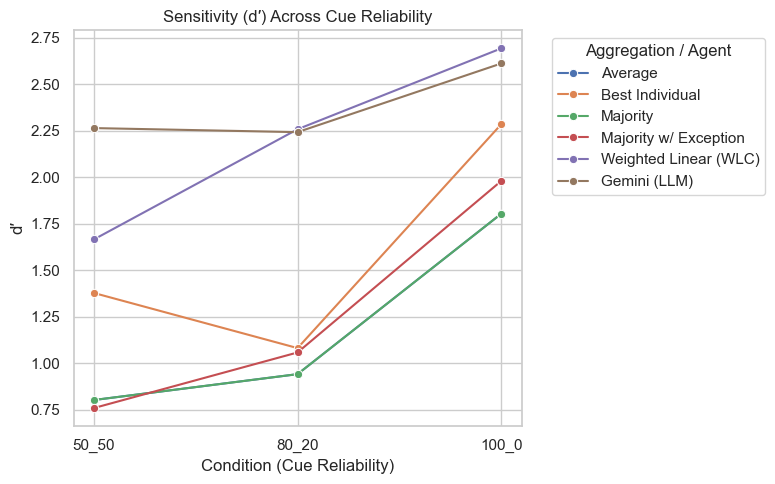

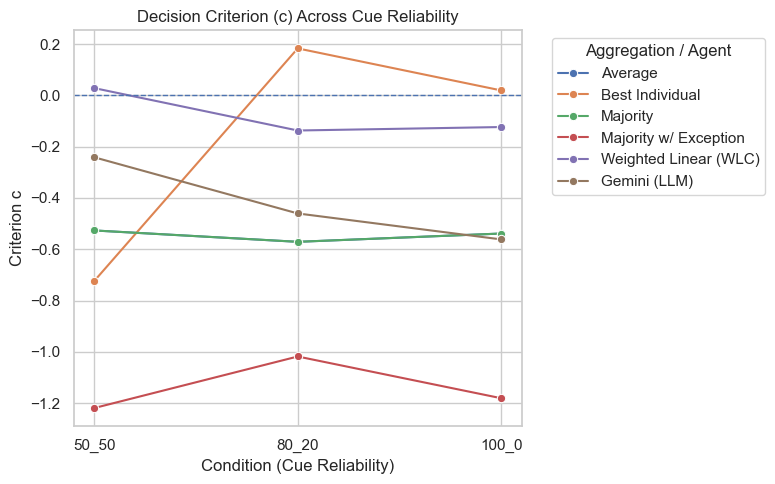

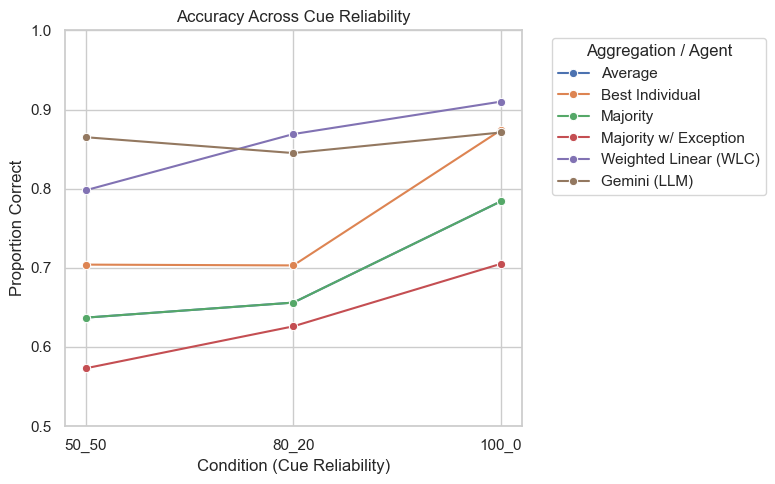

C:\Users\AdamR\AppData\Local\Temp\ipykernel_25052\452702411.py:124: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  piv = plot_df.pivot_table(


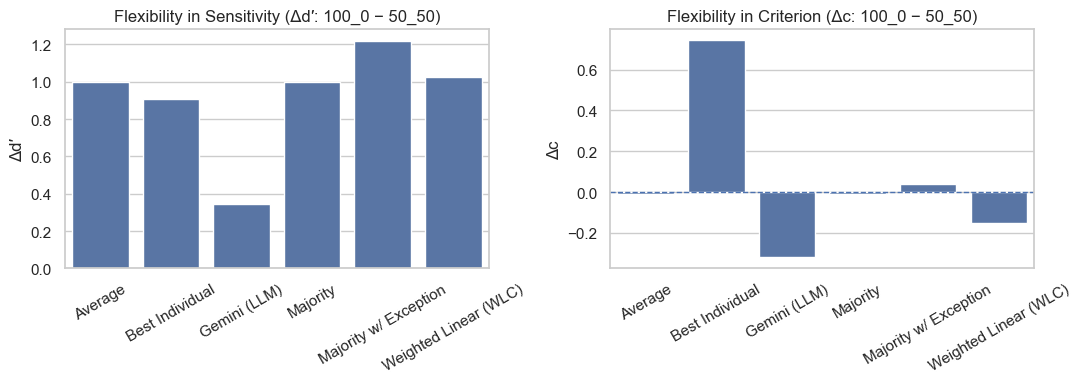

In [37]:
# %%
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 0. Choose the aggregation summary table to plot ---
if "agg_plus_wlc" in globals():
    plot_df = agg_plus_wlc.copy()
elif "agg_with_best" in globals():
    plot_df = agg_with_best.copy()
else:
    plot_df = agg_sdt.copy()

# -------------------------------------------------------
# 1. Add Gemini (model_sdt) into the same long-format DF
# -------------------------------------------------------
# model_sdt assumed from cueing.py; if not present, this will error
model_df = model_sdt.copy()

# compute accuracy for Gemini per condition
model_df["n_trials"] = model_df["n_sig"] + model_df["n_noise"]
model_df["accuracy"] = (model_df["hits"] + model_df["cr"]) / model_df["n_trials"]

# Align columns to match aggregation table
gemini_long = model_df.rename(columns={
    "hit_rate": "hit_rate",
    "fa_rate": "fa_rate",
})
gemini_long["aggregation"] = "gemini"
gemini_long = gemini_long[[
    "aggregation",
    "condition",
    "n_trials",
    "accuracy",
    "hit_rate",
    "fa_rate",
    "dprime",
    "criterion"
]]

# Attach Gemini rows to aggregation rows
plot_df = pd.concat([plot_df, gemini_long], ignore_index=True)

# ------------------------------
# 2. Clean labels & condition order
# ------------------------------
COND_ORDER = ["50_50", "80_20", "100_0"]
plot_df["condition"] = plot_df["condition"].astype(str)
plot_df["condition"] = pd.Categorical(plot_df["condition"], categories=COND_ORDER, ordered=True)

nice_names = {
    "maj": "Majority",
    "avg": "Average",
    "mwe": "Majority w/ Exception",
    "best_individual": "Best Individual",
    "wlc": "Weighted Linear (WLC)",
    "gemini": "Gemini (LLM)"
}
plot_df["aggregation_pretty"] = plot_df["aggregation"].map(nice_names).fillna(plot_df["aggregation"])

sns.set(style="whitegrid")

# =========================
# 3. d′ vs condition (with Gemini)
# =========================
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=plot_df,
    x="condition",
    y="dprime",
    hue="aggregation_pretty",
    marker="o"
)
plt.title("Sensitivity (d′) Across Cue Reliability")
plt.ylabel("d′")
plt.xlabel("Condition (Cue Reliability)")
plt.legend(title="Aggregation / Agent", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# =========================
# 4. c vs condition (with Gemini)
# =========================
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=plot_df,
    x="condition",
    y="criterion",
    hue="aggregation_pretty",
    marker="o"
)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Decision Criterion (c) Across Cue Reliability")
plt.ylabel("Criterion c")
plt.xlabel("Condition (Cue Reliability)")
plt.legend(title="Aggregation / Agent", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# =========================
# 5. Accuracy vs condition (with Gemini)
# =========================
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=plot_df,
    x="condition",
    y="accuracy",
    hue="aggregation_pretty",
    marker="o"
)
plt.ylim(0.5, 1.0)
plt.title("Accuracy Across Cue Reliability")
plt.ylabel("Proportion Correct")
plt.xlabel("Condition (Cue Reliability)")
plt.legend(title="Aggregation / Agent", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ====================================
# 6. Δc and Δd′ per aggregation/agent
#    (100_0 - 50_50), including Gemini
# ====================================
if set(COND_ORDER).issubset(set(plot_df["condition"].cat.categories)):
    piv = plot_df.pivot_table(
        index="aggregation_pretty",
        columns="condition",
        values=["dprime", "criterion"]
    )

    flex_df = pd.DataFrame({
        "aggregation_pretty": piv.index,
        "delta_dprime": piv[("dprime", "100_0")] - piv[("dprime", "50_50")],
        "delta_c":       piv[("criterion", "100_0")] - piv[("criterion", "50_50")]
    }).reset_index(drop=True)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=False)
    
    sns.barplot(
        data=flex_df,
        x="aggregation_pretty",
        y="delta_dprime",
        ax=axes[0]
    )
    axes[0].set_title("Flexibility in Sensitivity (Δd′: 100_0 − 50_50)")
    axes[0].set_ylabel("Δd′")
    axes[0].set_xlabel("")
    axes[0].tick_params(axis="x", rotation=30)

    sns.barplot(
        data=flex_df,
        x="aggregation_pretty",
        y="delta_c",
        ax=axes[1]
    )
    axes[1].axhline(0, linestyle="--", linewidth=1)
    axes[1].set_title("Flexibility in Criterion (Δc: 100_0 − 50_50)")
    axes[1].set_ylabel("Δc")
    axes[1].set_xlabel("")
    axes[1].tick_params(axis="x", rotation=30)

    plt.tight_layout()
    plt.show()


In [41]:
# %%
import json
import pickle

# 1. Aggregation + Gemini master summary
agg_plus_wlc.to_csv("agg_plus_wlc.csv", index=False)

plot_df.to_csv("Full_results.csv", index=False)

# 2. Trial-level aggregation decisions
trial_aggregates.to_csv("trial_aggregates.csv", index=False)

# 3. WLC weights + criteria
with open("wlc_weights.pkl", "wb") as f:
    pickle.dump(wlc_weights, f)

with open("wlc_criteria.json", "w") as f:
    json.dump(wlc_criteria, f, indent=2)

print("Saved CSVs + WLC parameters.")

# %%
import matplotlib.pyplot as plt

def save_fig(name):
    plt.savefig(name, bbox_inches="tight", dpi=300)

# ====================
# d′ figure
# ====================
plt.figure(figsize=(8, 5))
sns.lineplot(data=plot_df, x="condition", y="dprime", hue="aggregation_pretty", marker="o")
plt.title("Sensitivity (d′) Across Cue Reliability")
plt.ylabel("d′")
save_fig("fig_dprime.pdf")
plt.close()

# ====================
# criterion figure
# ====================
plt.figure(figsize=(8, 5))
sns.lineplot(data=plot_df, x="condition", y="criterion", hue="aggregation_pretty", marker="o")
plt.axhline(0, linestyle="--")
plt.title("Decision Criterion (c) Across Cue Reliability")
plt.ylabel("Criterion c")
save_fig("fig_criterion.pdf")
plt.close()

# ====================
# accuracy figure
# ====================
plt.figure(figsize=(8, 5))
sns.lineplot(data=plot_df, x="condition", y="accuracy", hue="aggregation_pretty", marker="o")
plt.title("Accuracy Across Cue Reliability")
plt.ylabel("Proportion Correct")
save_fig("fig_accuracy.pdf")
plt.close()

# ====================
# flexibility (Δd′ & Δc) figure
# ====================
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
sns.barplot(data=flex_df, x="aggregation_pretty", y="delta_dprime", ax=axes[0])
axes[0].set_title("Flexibility in Sensitivity (Δd′)")

sns.barplot(data=flex_df, x="aggregation_pretty", y="delta_c", ax=axes[1])
axes[1].axhline(0, linestyle="--")
axes[1].set_title("Flexibility in Criterion (Δc)")

save_fig("fig_flexibility.pdf")
plt.close()

print("Saved all figures as PDF.")


Saved CSVs + WLC parameters.
Saved all figures as PDF.
